## Let's build a multimodal from scratch!
This isn't about the hype, this is truly for lovers of LLMs and the actual math behind it. If you're one of them like me, you're more than welcome to join my [discord server](https://discord.gg/PRs84AnxtT)!

### But what is a LLM anyway?

A Large Language Model (LLM) is a type of artificial intelligence model designed to understand, generate, and manipulate human language. These models are trained on vast amounts of text data and can perform a wide variety of language tasks such as translation, summarization, question answering, and text generation.

For a more in-depth understanding, check out this explanatory video:

[[ 1 hr Talk ] Intro to Large Language Models by Andrej Karpathy](https://www.youtube.com/embed/zjkBMFhNj_g)

<iframe width="560" height="315" src="https://www.youtube.com/embed/zjkBMFhNj_g" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>



#### Note

1. Here's how I have divided my project structure and pipeline
```
├── models/              # Encoders & fusion layers
├── data/                # Processing scripts
├── training/            # Contrastive loss implementation
├── explainability/      # Attention visualization tools
├── demo/                # Gradio interface
```

2. This project is solely for my learning purpose and love for artificial intelligence, I do not plan to advertise, boast or take advantage of people for helping on this project. You're more than welcome to use this project in your resume or anywhere you'd like as a collaborator for credit.

---

# Text-based LLM

## Step 1 - Environment Setup

1. Create python environment `python -m venv venv`
2. Install dependencies `pip install -r requirements.txt`
3. Login with your [huggingface account](https://huggingface.co/docs/hub/datasets-usage)
4. Searching for best possible text data given our time, commitment and constraints. We'll use [TinyStories dataset](https://huggingface.co/datasets/roneneldan/TinyStories) since it's really high quality and easy to train

In [22]:
%pip install --quiet --upgrade pip
%pip install --quiet -r requirements.txt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Login with HuggingFace using token from environment variables
from huggingface_hub import login
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Get token from environment variables
huggingface_token = os.getenv("HUGGING_FACE_TOKEN")

# Login with your token
login(token=huggingface_token, add_to_git_credential=True)


/home/ash/projects/ExplainableAI/venv/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from datasets import load_dataset

# After successful login, load the dataset
ds = load_dataset("roneneldan/TinyStories")

## Step 2 - Data Analysis

It's crucial to analyze the data you're feeding to the model. Data is one of the most important things when it comes to LLMs, a bad, inconsistent data can make your model inevitable.

For this purpose, in `explanability/` folder, I've included all functions which can accelerate this process of learning.

Let's utilize them to see what this data is all about.

<module 'explanability.four_pillars' from '/home/ash/projects/ExplainableAI/explanability/four_pillars.py'>
Analyzing dataset for the four pillars of explainability...

📊 PILLAR 1: DATA DISTRIBUTION


<Figure size 2000x2000 with 0 Axes>

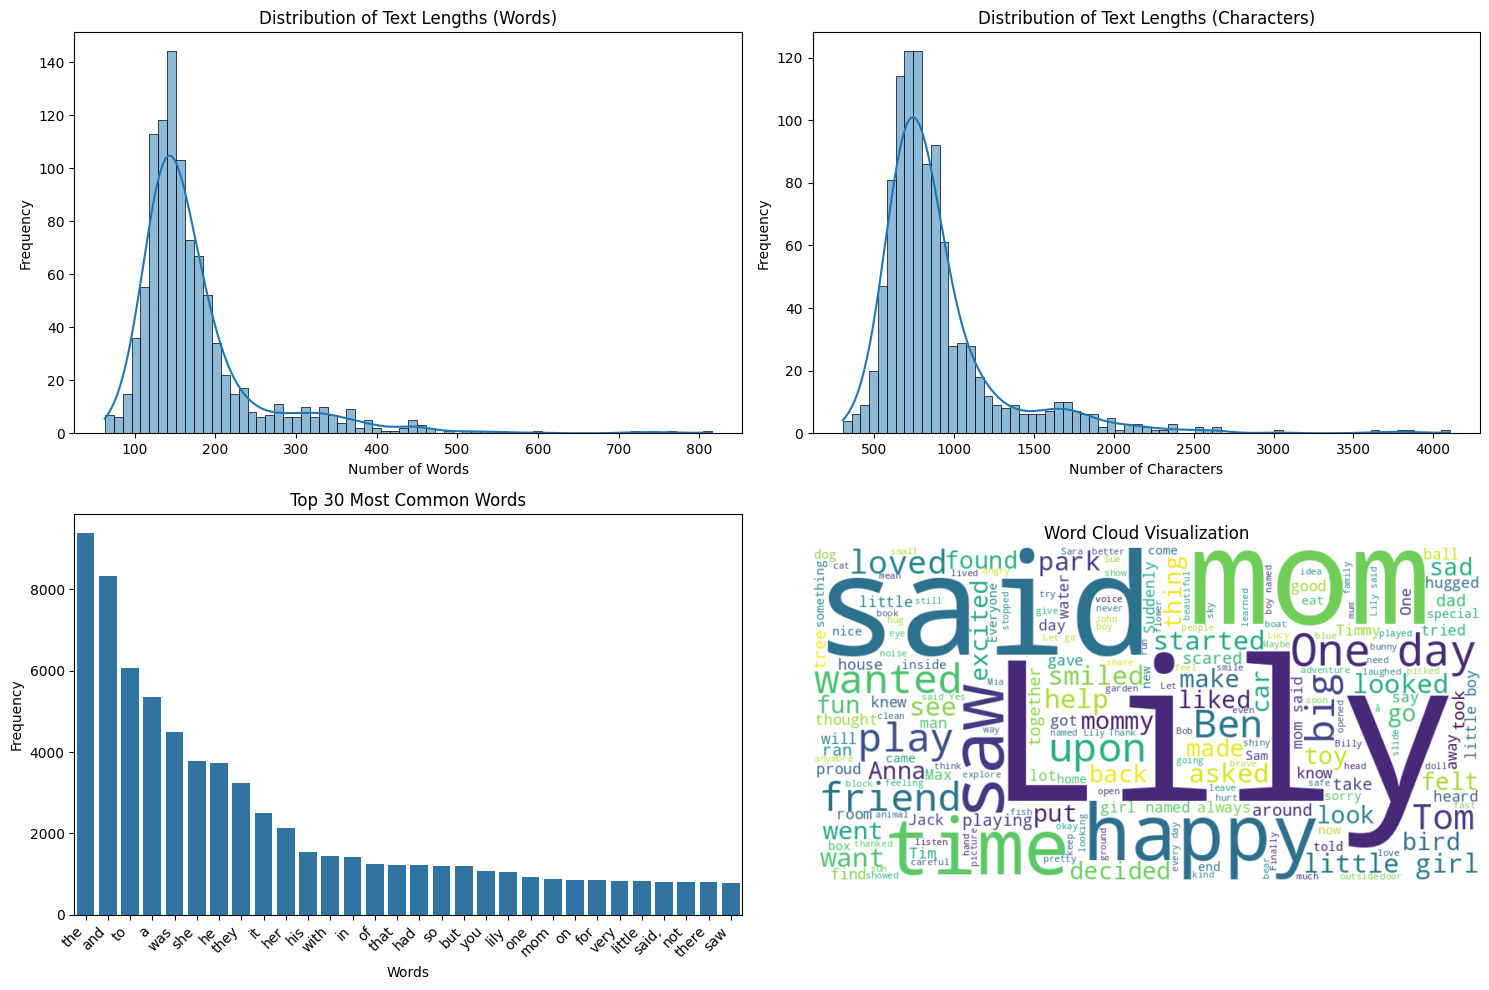

Average text length: 175.83 words
Median text length: 152.00 words
Vocabulary size: 10027 unique words

🧩 PILLAR 2: SEMANTIC PATTERNS


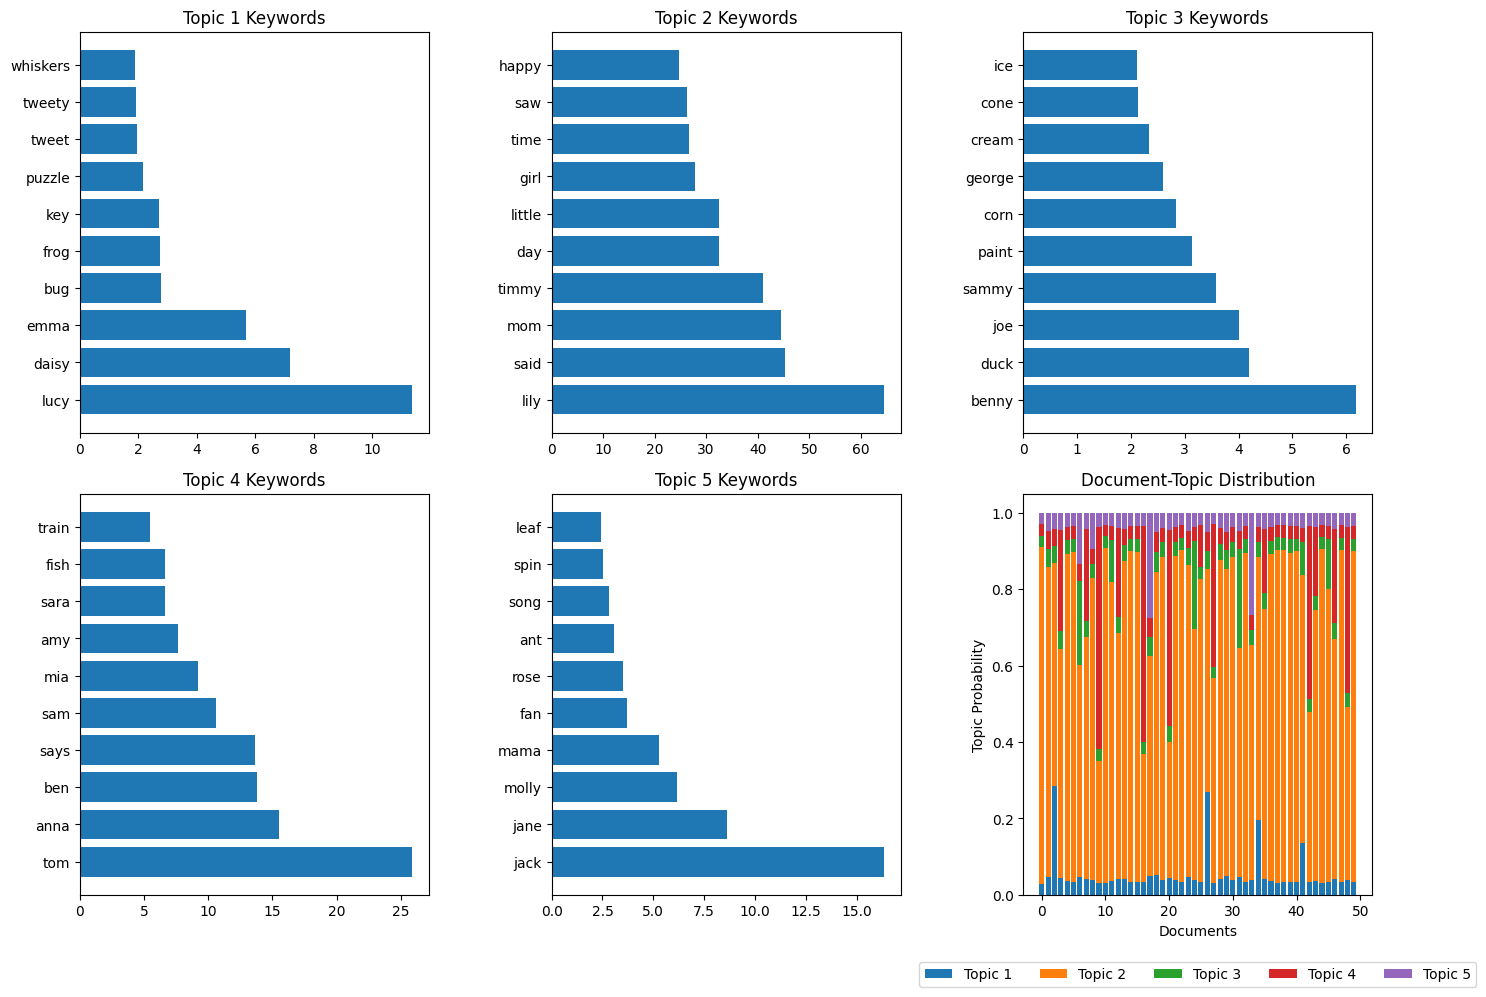

Number of topics analyzed: 5
Top keywords for each topic:
  Topic 1: lucy, daisy, emma, bug, frog
  Topic 2: lily, said, mom, timmy, day
  Topic 3: benny, duck, joe, sammy, paint
  Topic 4: tom, anna, ben, says, sam
  Topic 5: jack, jane, molly, mama, fan

📝 PILLAR 3: LINGUISTIC FEATURES


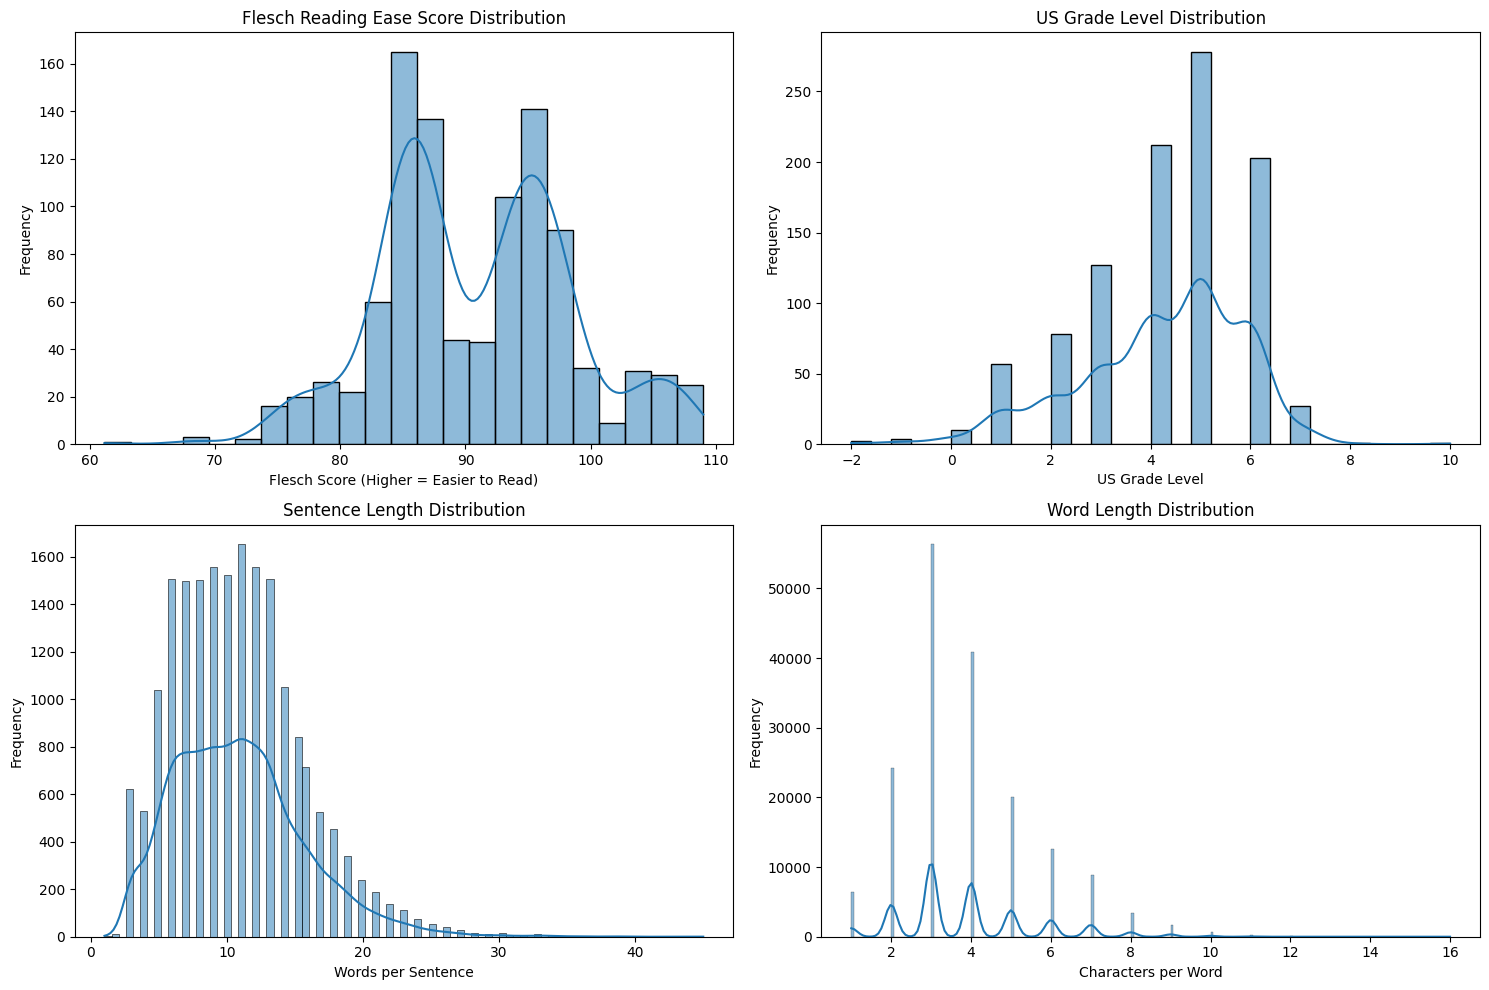

Average Flesch Reading Ease: 90.83 (90-100: Very Easy, 0-30: Very Difficult)
Average US Grade Level: 4.25
Average Sentence Length: 10.87 words
Average Word Length: 3.87 characters

🔄 PILLAR 4: TOKEN RELATIONSHIPS


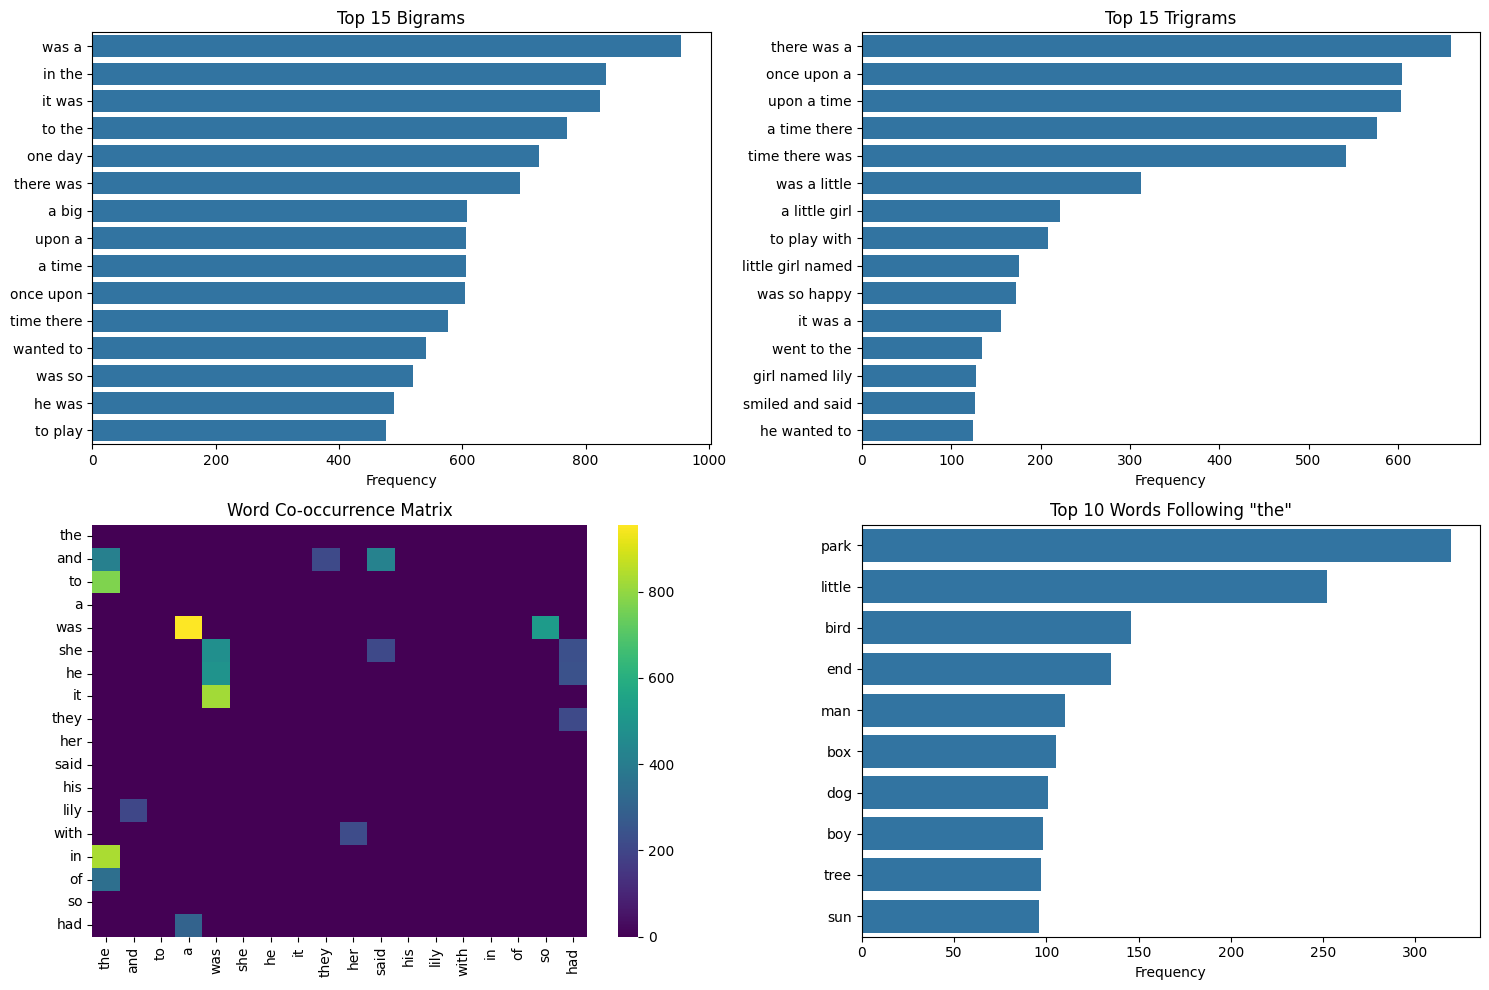

Most common bigram: was a (occurs 955 times)
Most common trigram: there was a (occurs 659 times)
Words most likely to follow 'the': park, little, bird


<Figure size 640x480 with 0 Axes>

Analysis complete! These visualizations provide insights into the dataset's characteristics.


In [ ]:
from explanability import four_pillars
four_pillars.visualize(ds)